In [18]:
import numpy as np

# データの読み込み
file_path = 'processed_data/all_data_combined.npz'
data = np.load(file_path, allow_pickle=True)

# 保存されているデータのキーを確認
print("Keys:", data.files)

# カラム名を表示（何番目が何のデータか確認するため）
cols = data['columns']
print(f"\n--- Column Names (Total: {len(cols)}) ---")
for i, col in enumerate(cols):
    print(f"{i}: {col}")

# データの形状確認
ensemble = data['ensemble']
subject_ids = data['subject_ids']

print("\nEnsemble Shape:", ensemble.shape)     # (サンプル数, 時間, 特徴量)
print("Subject IDs Shape:", subject_ids.shape) # (サンプル数,)

Keys: ['ensemble', 'subject_ids', 'columns', 'id_map']

--- Column Names (Total: 26) ---
0: Pressure_1
1: Pressure_2
2: Pressure_3
3: Pressure_4
4: Pressure_5
5: Pressure_6
6: Pressure_7
7: Pressure_8
8: Accel_X
9: Accel_Y
10: Accel_Z
11: Gyro_X
12: Gyro_Y
13: Gyro_Z
14: Hip_XY
15: Hip_YZ
16: Hip_ZX
17: Knee_XY
18: Knee_YZ
19: Knee_ZX
20: Ankle_XY
21: Ankle_YZ
22: Ankle_ZX
23: Fx
24: Fy
25: Fz

Ensemble Shape: (13007, 200, 26)
Subject IDs Shape: (13007,)


In [21]:
import numpy as np

# 1. 入力(X)と正解(y)の切り出し（前回と同じ）
X_all = ensemble[:, :, :23]
y_all = ensemble[:, :, 23:]

# 2. 被験者IDごとの分割設定
# 全被験者のIDリストを取得
unique_subjects = np.unique(subject_ids)
print(f"全被験者ID: {unique_subjects}")

# --- ここで分割するIDを指定します ---
# 例: ID 10, 11 をテスト(完全未知)にする
test_sub_ids = [10, 11] 
# 例: ID 8, 9 を検証用(学習中に精度を見るための未知データ)にする
val_sub_ids  = [8, 9]   
# 残りを学習用にする
train_sub_ids = [0, 1, 2, 3, 4, 5, 6, 7]

print(f"\n--- Split Config ---")
print(f"Train IDs: {train_sub_ids}")
print(f"Val   IDs: {val_sub_ids}")
print(f"Test  IDs: {test_sub_ids}")

# 3. マスク作成とデータの抽出
# np.isin を使って、該当するIDのデータ位置(True/False)を取得します
train_mask = np.isin(subject_ids, train_sub_ids)
val_mask   = np.isin(subject_ids, val_sub_ids)
test_mask  = np.isin(subject_ids, test_sub_ids)

# データ分割実行
X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

print(f"\n--- Data Split Completed (Subject-wise) ---")
print(f"Train : X={X_train.shape}, y={y_train.shape}")
print(f"Val   : X={X_val.shape},   y={y_val.shape}")
print(f"Test  : X={X_test.shape},  y={y_test.shape}")

# 確認: データ混入がないかチェック
train_ids_check = np.unique(subject_ids[train_mask])
test_ids_check = np.unique(subject_ids[test_mask])
intersect = np.intersect1d(train_ids_check, test_ids_check)
if len(intersect) == 0:
    print("OK: 学習データとテストデータに重複する被験者はいません。")
else:
    print(f"WARNING: データ混入があります -> {intersect}")

全被験者ID: [ 0  1  2  3  4  5  6  7  8  9 10 11]

--- Split Config ---
Train IDs: [0, 1, 2, 3, 4, 5, 6, 7]
Val   IDs: [8, 9]
Test  IDs: [10, 11]

--- Data Split Completed (Subject-wise) ---
Train : X=(8527, 200, 23), y=(8527, 200, 3)
Val   : X=(2128, 200, 23),   y=(2128, 200, 3)
Test  : X=(2352, 200, 23),  y=(2352, 200, 3)
OK: 学習データとテストデータに重複する被験者はいません。


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# ---  Tensor化とDataLoaderの作成 ---

BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensorへの変換関数 (float32にキャスト)
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

# Numpy配列を直接Tensorに変換
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)

X_val_tensor   = to_tensor(X_val)
y_val_tensor   = to_tensor(y_val)

X_test_tensor  = to_tensor(X_test)
y_test_tensor  = to_tensor(y_test)

# Datasetの作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Ready ---")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")
print(f"Using device: {device}")


--- DataLoader Ready ---
Train batches: 134
Val   batches: 34
Test  batches: 37
Using device: cpu


In [23]:
import torch.nn as nn

class LSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMRegression, self).__init__()
        
        # LSTM層
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, # (Batch, Seq, Feature)
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # 全結合層 (回帰用)
        # LSTMの隠れ層(hidden_dim)から、出力次元(output_dim=3)に変換
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (Batch, 200, 23)
        
        # LSTMの出力
        # r_out shape: (Batch, 200, hidden_dim)
        r_out, (h_n, h_c) = self.lstm(x)
        
        # 全時刻のデータをLinear層に通す
        # PyTorchのLinearは (Batch, Seq, Hidden) を入力すると、
        # 末尾の次元だけ変換して (Batch, Seq, Output) にしてくれます
        output = self.fc(r_out)
        
        return output # shape: (Batch, 200, 3)

# --- モデルのインスタンス化 ---
INPUT_DIM = 23    # IMU, Pressureなど
HIDDEN_DIM = 64   # 隠れ層のサイズ (CPUなので64程度で試します)
NUM_LAYERS = 2    # 層の深さ
OUTPUT_DIM = 3    # Fx, Fy, Fz

model = LSTMRegression(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM).to(device)
print(model)

# 試しにランダムデータを入力して出力形状を確認
dummy_input = torch.randn(2, 200, 23).to(device) # バッチサイズ2
dummy_out = model(dummy_input)
print(f"\n入出力チェック: Input {dummy_input.shape} -> Output {dummy_out.shape}")
# 期待される出力: torch.Size([2, 200, 3])

LSTMRegression(
  (lstm): LSTM(23, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

入出力チェック: Input torch.Size([2, 200, 23]) -> Output torch.Size([2, 200, 3])


学習開始 (Device: cpu, Epochs: 30)
Epoch [1/30] | Train Loss(MSE): 0.02589 | Val Loss(MSE): 0.02682
Epoch [2/30] | Train Loss(MSE): 0.00466 | Val Loss(MSE): 0.02154
Epoch [3/30] | Train Loss(MSE): 0.00312 | Val Loss(MSE): 0.01924
Epoch [4/30] | Train Loss(MSE): 0.00257 | Val Loss(MSE): 0.01540
Epoch [5/30] | Train Loss(MSE): 0.00214 | Val Loss(MSE): 0.01189
Epoch [6/30] | Train Loss(MSE): 0.00186 | Val Loss(MSE): 0.01151
Epoch [7/30] | Train Loss(MSE): 0.00166 | Val Loss(MSE): 0.01096
Epoch [8/30] | Train Loss(MSE): 0.00152 | Val Loss(MSE): 0.01028
Epoch [9/30] | Train Loss(MSE): 0.00141 | Val Loss(MSE): 0.00959
Epoch [10/30] | Train Loss(MSE): 0.00131 | Val Loss(MSE): 0.00893
Epoch [11/30] | Train Loss(MSE): 0.00125 | Val Loss(MSE): 0.00922
Epoch [12/30] | Train Loss(MSE): 0.00122 | Val Loss(MSE): 0.00794
Epoch [13/30] | Train Loss(MSE): 0.00114 | Val Loss(MSE): 0.00791
Epoch [14/30] | Train Loss(MSE): 0.00108 | Val Loss(MSE): 0.00786
Epoch [15/30] | Train Loss(MSE): 0.00107 | Val Loss(MS

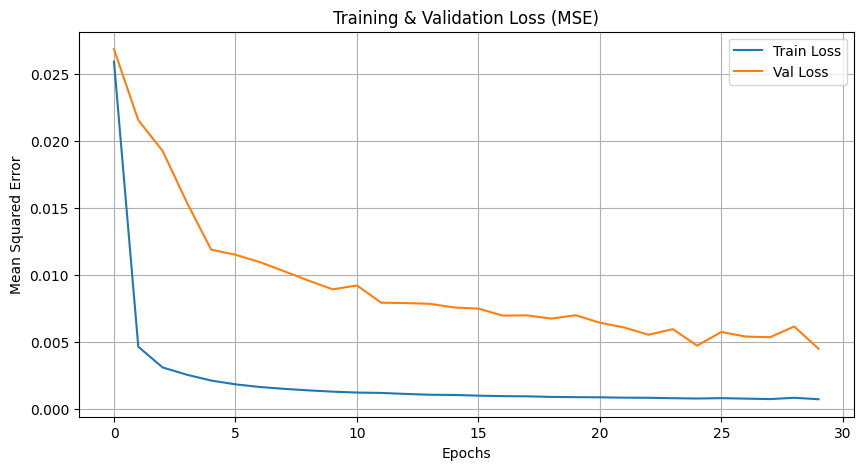

In [24]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# 設定
lr = 0.001
EPOCHS = 30  # 十分な収束のため30回ほど回します

# 損失関数とオプティマイザ
criterion = nn.MSELoss() # 回帰なのでMSE
optimizer = optim.Adam(model.parameters(), lr=lr)

# ログ用リスト
train_losses = []
val_losses = []

print(f"学習開始 (Device: {device}, Epochs: {EPOCHS})")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs) # (Batch, 200, 3)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # 5エポックごとに経過を表示
    if (epoch + 1) % 1 == 0: # 毎回表示に変更（CPUだと進捗が不安になるため）
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss(MSE): {epoch_train_loss:.5f} | Val Loss(MSE): {epoch_val_loss:.5f}")

total_time = time.time() - start_time
print(f"\n学習完了. 所要時間: {total_time:.1f}秒")

# --- 学習曲線のプロット ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Test Predictions Shape: (2352, 200, 3)

--- Test Evaluation Results (Unknown Subjects) ---
RMSE (Overall): 0.15303
Correlation (Fx - 左右): 0.6702
Correlation (Fy - 前後): 0.6502
Correlation (Fz - 垂直): 0.8563


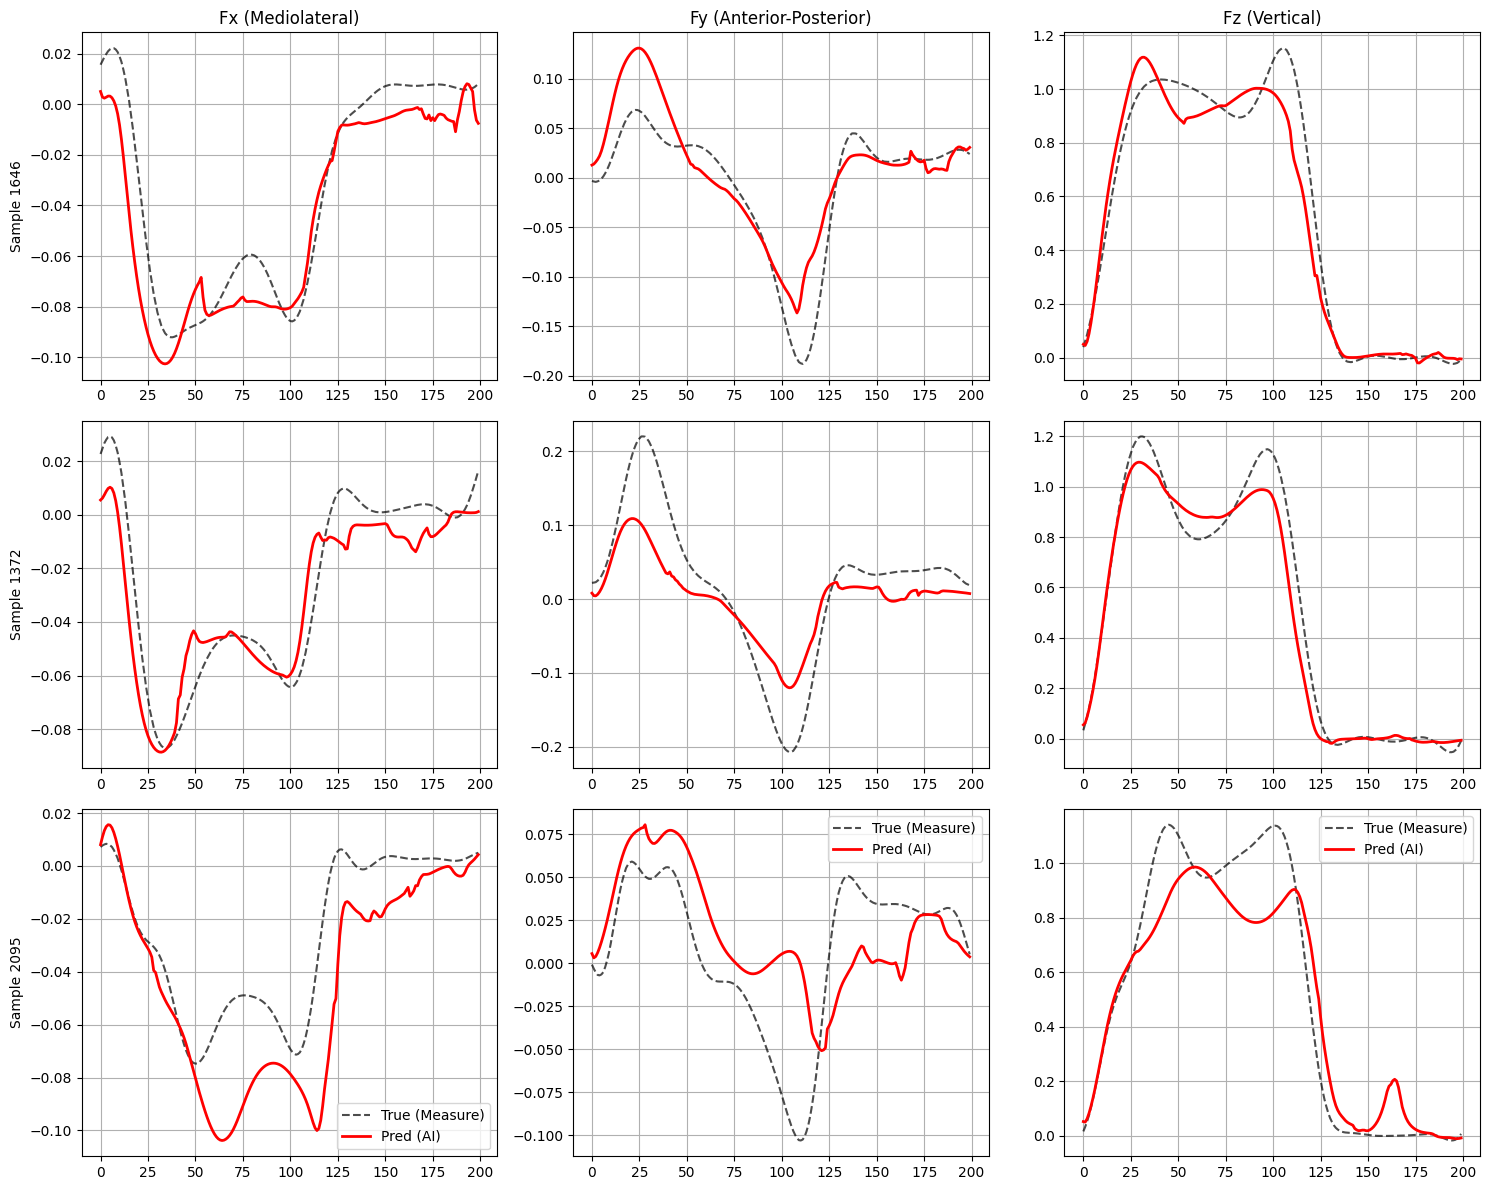

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. テストデータでの推論実行
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # データをCPUに戻してリストに追加
        test_preds.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

# numpy配列に結合 (サンプル数, 200, 3)
test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

print(f"Test Predictions Shape: {test_preds.shape}")

# 2. 評価指標の計算 (全体平均)
mse = mean_squared_error(test_targets.reshape(-1, 3), test_preds.reshape(-1, 3))
rmse = np.sqrt(mse)

# 相関係数 (各軸ごとの平均)
# Flattenして計算
corr_fx = np.corrcoef(test_targets[:, :, 0].flatten(), test_preds[:, :, 0].flatten())[0, 1]
corr_fy = np.corrcoef(test_targets[:, :, 1].flatten(), test_preds[:, :, 1].flatten())[0, 1]
corr_fz = np.corrcoef(test_targets[:, :, 2].flatten(), test_preds[:, :, 2].flatten())[0, 1]

print(f"\n--- Test Evaluation Results (Unknown Subjects) ---")
print(f"RMSE (Overall): {rmse:.5f}")
print(f"Correlation (Fx - 左右): {corr_fx:.4f}")
print(f"Correlation (Fy - 前後): {corr_fy:.4f}")
print(f"Correlation (Fz - 垂直): {corr_fz:.4f}")

# 3. 波形の可視化 (ランダムにいくつかの歩行を抽出)
# 比較しやすいよう、ランダムに3つのサンプルを選んで表示します
num_samples = 3
sample_indices = np.random.choice(len(test_preds), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
axis_names = ['Fx (Mediolateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']

for i, idx in enumerate(sample_indices):
    for j in range(3): # Fx, Fy, Fz
        ax = axes[i, j]
        true_wave = test_targets[idx, :, j]
        pred_wave = test_preds[idx, :, j]
        
        ax.plot(true_wave, label='True (Measure)', color='black', linestyle='--', alpha=0.7)
        ax.plot(pred_wave, label='Pred (AI)', color='red', linewidth=2)
        
        if i == 0: ax.set_title(axis_names[j])
        if j == 0: ax.set_ylabel(f"Sample {idx}")
        ax.grid(True)
        if i == num_samples - 1: ax.legend()

plt.tight_layout()
plt.show()

データをロード中...
★デバッグモード: データを 5000 サンプルに制限しました！
--- データセット分割結果 ---
全体: 5000
学習 (Train): 3600 [モデル更新用]
検証 (Val)  : 900   [Bestモデル保存用]
評価 (Test) : 500  [最終評価用]
学習開始... (Device: cpu, Epochs: 20)
Epoch [1/20] Train Loss: 0.0147, Val Loss: 0.0031
Epoch [5/20] Train Loss: 0.0014, Val Loss: 0.0013
Epoch [10/20] Train Loss: 0.0010, Val Loss: 0.0013
Epoch [15/20] Train Loss: 0.0009, Val Loss: 0.0010
Epoch [20/20] Train Loss: 0.0008, Val Loss: 0.0009
学習終了！


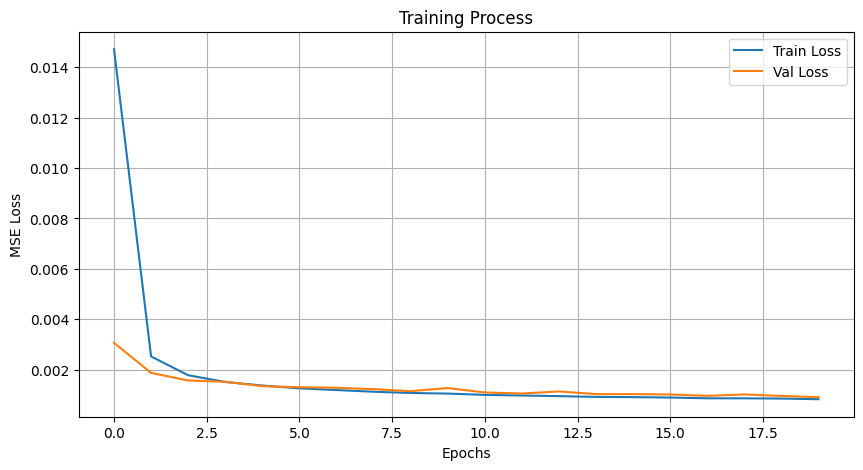

In [ ]:
# --- 実行部分 ---
if __name__ == "__main__":
    file_path = 'processed_data/all_data_combined.npz'
    
    # ★ここでデータ数を指定（例: 500個だけで試す）
    train_loader, val_loader, test_loader = prepare_dataloaders(file_path, limit=5000) # デバッグ用にデータ数制限
    
    EPOCHS = 30
    LR = 0.001
    
    # モデル再定義
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GRFPredictorLSTM(input_size=14, output_size=3).to(device)
    
    # 学習実行
    train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, 
                                                       num_epochs=20, # エポック数も少なめでOK
                                                       learning_rate=0.001, 
                                                       device=device)
    
    # 学習曲線の描画
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training Process')
    plt.grid(True)
    plt.show()

予測結果を可視化します...


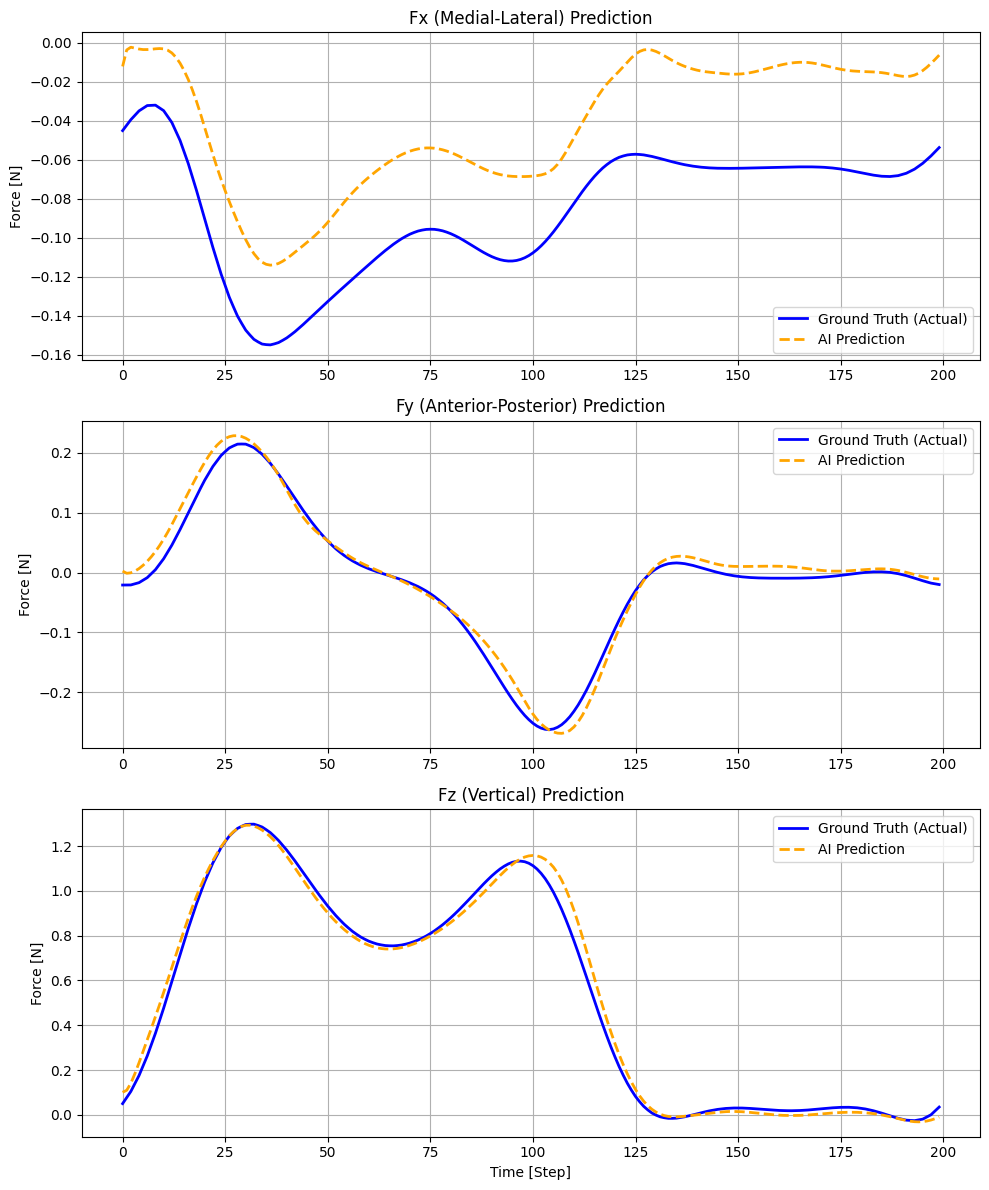

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(model, test_loader, device, sample_index=0):
    """
    model: 学習済みモデル
    test_loader: テスト用データローダー
    device: 'cuda' or 'cpu'
    sample_index: バッチ内のどの歩行データを表示するか (0〜batch_size-1)
    """
    model.eval() # 評価モード
    
    # 1バッチだけデータを取り出す
    x_batch, y_batch = next(iter(test_loader))
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # 予測を実行
    with torch.no_grad():
        preds = model(x_batch)

    # Tensor -> NumPy に変換 (グラフ描画のため)
    # shape: (Batch, Time, 3)
    y_true = y_batch.cpu().numpy()
    y_pred = preds.cpu().numpy()

    # 指定したサンプルのデータを取り出す
    true_sample = y_true[sample_index] # (200, 3)
    pred_sample = y_pred[sample_index] # (200, 3)

    # --- グラフ描画 ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    axis_names = ['Fx (Medial-Lateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']

    # Fx, Fy, Fz それぞれプロット
    for i in range(3):
        ax = axes[i]
        ax.plot(true_sample[:, i], label='Ground Truth (Actual)', color='blue', linewidth=2)
        ax.plot(pred_sample[:, i], label='AI Prediction', color='orange', linestyle='--', linewidth=2)
        ax.set_title(f'{axis_names[i]} Prediction')
        ax.set_ylabel('Force [N]')
        ax.legend()
        ax.grid(True)

    plt.xlabel('Time [Step]')
    plt.tight_layout()
    plt.show()

# --- 実行方法 ---
# 学習ループ(train_model)が終わった後に呼び出してください
if __name__ == "__main__":
    # 上記の train_model のコードの続きとして実行
    print("予測結果を可視化します...")
    visualize_prediction(model, val_loader, device, sample_index=0)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    # 1. 全検証データの予測を収集
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            preds = model(x_batch)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # リストを結合して大きな配列にする
    # shape: (データ数, 200, 3)
    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_targets, axis=0)

    # 2. 軸ごとの評価 (Fx, Fy, Fz)
    axis_names = ['Fx', 'Fy', 'Fz']
    
    print("\n--- 精度評価結果 (Evaluation Metrics) ---")
    print(f"{'Axis':<5} | {'RMSE [Z-Score]':<10} | {'Correlation (R)':<15}")
    print("-" * 35)

    for i in range(3):
        # データを1次元に平坦化して計算 (全時刻・全サンプルをまとめる)
        true_flat = y_true[:, :, i].flatten()
        pred_flat = y_pred[:, :, i].flatten()

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(true_flat, pred_flat))

        # 相関係数(R)計算
        corr = np.corrcoef(true_flat, pred_flat)[0, 1]

        print(f"{axis_names[i]:<5} | {rmse:.4f}     | {corr:.4f}")

# --- 実行 ---
if __name__ == "__main__":
    evaluate_metrics(model, val_loader, device)


--- 精度評価結果 (Evaluation Metrics) ---
Axis  | RMSE [Z-Score] | Correlation (R)
-----------------------------------
Fx    | 0.0194     | 0.8764
Fy    | 0.0204     | 0.9802
Fz    | 0.0439     | 0.9958
